# IMPORTS

In [ ]:
import pandas as pd
import html
import unicodedata
from bs4 import BeautifulSoup
import re
import os
import requests
from time import sleep

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# WEB SCRAPPING

In [ ]:
#an ugly function to get from e-obuwie lists with main information

def input_for_df(http_address):
  """returnig from adverts 3 lists of names, extended names and links to images of shoes"""
  
  response = requests.get(http_address)
  content = response.content.decode('utf-8')
  content = html.unescape(content)
  content = unicodedata.normalize('NFKD', content)

  soup = BeautifulSoup(content, 'html.parser')
  data = soup.find_all('a',attrs={'class':'products-list__link'})
  shoes_names=[]
  shoes_images = []
  shoes_IMAGE = []
  new_names = []
  links = []
  normal_price = []
  special_price = []

  for item in data:
    spans = item.find_all('span',attrs={'class':'products-list__name-first'})
    shoes_names.append(spans[0].text.replace('\n',''))

    links.append(item['href'][2:])

    image = item.find_all('img')
    shoes_images.append(image[0])

    if item.find('div',attrs={'class':"products-list__regular-price"}) is not None:
      price = item.find('div',attrs={'class':"products-list__regular-price"})
      price = float(price.text.replace('\n','').replace(' zł ','').replace(',','.').replace(' ',''))
      price_new = 0
      normal_price.append(price)
      special_price.append(price_new)

    elif item.find('div',attrs={'class':"products-list__old-price"}) is not None:
      price = item.find('div',attrs={'class':"products-list__old-price"})
      price = float(price.text.replace('\n','').replace(' zł ','').replace(',','.').replace(' ',''))
      price_new = item.find('div',attrs={'class':"products-list__special-price"})
      price_new = float(price_new.text.replace('\n','').replace(' zł ','').replace(',','.').replace(' ',''))
      normal_price.append(price)
      special_price.append(price_new)
    else:
      print('error')
   

  for item in shoes_images:
    if item.has_attr('alt'):
      new_names.append(item['alt'])  
    if item.has_attr('data-src'):
      shoes_IMAGE.append(item['data-src'])
  return shoes_names,new_names,shoes_IMAGE, links, normal_price, special_price

In [ ]:
# function to iterate through pages on the main page e-obuwie from page k_0 to k

def new_get_pages_links(url_address,k_0, k):
  links_list = []
    
  for i in range(k_0,k):
    try:
      response = requests.get(url_address+"?p={}".format(i))
      sleep(0.1)
      soup = BeautifulSoup(response.content, 'html.parser')
      for item in soup.find_all("a", {"class": "toolbar-bottom__pager-item"}):
        if item.has_attr('href'):
          links_list.append('http://{}'.format(item['href'].replace('//','')))
    except:
      pass

  return list(set(links_list))

In [ ]:
# creating dataframe with data from web, append has to be replaced with concat in the future

links = ['https://www.eobuwie.com.pl/damskie/sportowe.html', 'https://www.eobuwie.com.pl/damskie/polbuty.html',
         'https://www.eobuwie.com.pl/damskie/kozaki-i-inne.html', 'https://www.eobuwie.com.pl/damskie/klapki-i-sandaly.html']
data = pd.DataFrame(columns = ['subcategory','shoes_description','image_link', 'shoes_link','normal_price', 'special_price','main_category'])

for address in links:

  for link in new_get_pages_links(address, 2, 50):
    shoes_names,new_names,shoes_IMAGE, links, normal_price, special_price = input_for_df(link)
    category = re.split('/',address)[-1][:-5]
    df = pd.DataFrame(list(zip(shoes_names,new_names,shoes_IMAGE, links, normal_price, special_price)))
    df['main_category'] = category
    try:
      df.columns=data.columns
      data = data.append(df,ignore_index=True)
    except:
      pass


In [ ]:
data['main_category'].value_counts()

kozaki-i-inne       7815
klapki-i-sandaly    7749
polbuty             7718
sportowe            5057
Name: main_category, dtype: int64

In [ ]:
data.sample(5)

,subcategory,shoes_description,image_link,links,normal_price,special_price,main_category
1670,Botki MICHAEL Michael Kors,Botki MICHAEL Michael Kors - Alina Flex Bootie...,https://img.eobuwie.cloud/eob1_product_300w(d/...,www.eobuwie.com.pl/botki-michael-michael-kors-...,1069.00,689.99,kozaki-i-inne
523,Buty adidas,Buty adidas - Tensaur Sport 2.0 K GW6423 Cloud...,https://www.eobuwie.com.pl/media/catalog/produ...,www.eobuwie.com.pl/buty-adidas-tensaur-sport-2...,159.99,0.00,sportowe
1360,Botki ALTERCORE,Botki ALTERCORE - Enid Vegan White,https://www.eobuwie.com.pl/media/catalog/produ...,www.eobuwie.com.pl/botki-altercore-enid-vegan-...,529.99,0.00,kozaki-i-inne
698,Sneakersy GINO ROSSI,Sneakersy GINO ROSSI - WI16-POLAND-03 Green,https://www.eobuwie.com.pl/media/catalog/produ...,www.eobuwie.com.pl/sneakersy-gino-rossi-wi16-p...,279.99,139.99,polbuty
1984,Kapcie Toms,Kapcie Toms - Ezra 10018793 Black Melange Felt,https://img.eobuwie.cloud/eob1_product_300w(6/...,www.eobuwie.com.pl/kapcie-toms-ezra-10018793-b...,289.99,219.99,klapki-i-sandaly


## Save data

In [ ]:
#save the data in the form of df
import pickle
pickle.dump(data,open('/content/drive/MyDrive/eobuwie/basic_data.pickle',mode='wb'))

## Basic charts

In [ ]:
#download the data
import pickle
df = pickle.load(open('/content/drive/MyDrive/eobuwie/basic_data.pickle',mode='rb'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28339 entries, 0 to 28338
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   subcategory        28339 non-null  object 
 1   shoes_description  28339 non-null  object 
 2   image_link         28339 non-null  object 
 3   shoes_link         28339 non-null  object 
 4   normal_price       28339 non-null  float64
 5   special_price      28339 non-null  float64
 6   main_category      28339 non-null  object 
dtypes: float64(2), object(5)
memory usage: 1.5+ MB


In [ ]:
df['main_category'].value_counts()

kozaki-i-inne       7815
klapki-i-sandaly    7749
polbuty             7718
sportowe            5057
Name: main_category, dtype: int64

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

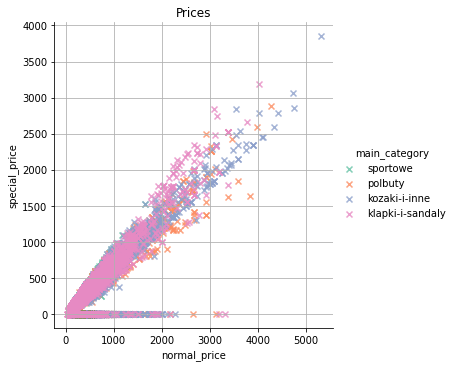

In [ ]:
ax = sns.lmplot(x='normal_price', y='special_price', data = df, fit_reg=False,
                hue='main_category', markers=['x','x','x','x'], palette='Set2')

ax.set(title='Prices')
ax.set(xlabel='normal_price', ylabel='special_price')
plt.grid('major')

In [ ]:
df['normal_price'].describe()

count    28339.000000
mean       498.237466
std        368.570944
min         29.990000
25%        289.990000
50%        399.990000
75%        599.990000
max       5299.000000
Name: normal_price, dtype: float64

In [ ]:
#shoes with discount
df[df['special_price']>0].describe()

,normal_price,special_price
count,22743.000000,22743.000000
mean,525.838183,370.099307
std,381.273824,260.629271
min,49.990000,39.990000
25%,299.990000,219.990000
50%,429.990000,299.990000
75%,629.000000,439.990000
max,5299.000000,3849.000000


In [ ]:
df[df['special_price']==0]

,subcategory,shoes_description,image_link,shoes_link,normal_price,special_price,main_category
2,Buty Reebok,Buty Reebok - Royal Cl Jog 3.0 GW5233 Ftwwht/F...,https://www.eobuwie.com.pl/media/catalog/produ...,www.eobuwie.com.pl/buty-reebok-royal-cl-jog-3-...,159.99,0.0,sportowe
3,Buty Reebok,Buty Reebok - Rush Runner 4.0 GW0003 Astpnk/Si...,https://www.eobuwie.com.pl/media/catalog/produ...,www.eobuwie.com.pl/buty-reebok-rush-runner-4-0...,129.99,0.0,sportowe
4,Buty Reebok,Buty Reebok - Rush Runner 4.0 Sy GV9994 Porpnk...,https://www.eobuwie.com.pl/media/catalog/produ...,www.eobuwie.com.pl/buty-reebok-rush-runner-4-0...,129.99,0.0,sportowe
7,Buty Reebok,Buty Reebok - Royal Glide Ripple FY4639 Black/...,https://www.eobuwie.com.pl/media/catalog/produ...,www.eobuwie.com.pl/buty-reebok-royal-glide-rip...,199.99,0.0,sportowe
23,Buty HOKA ONE ONE,Buty HOKA ONE ONE - Rincon 3 Wide 1121371 Blk/wht,https://www.eobuwie.com.pl/media/catalog/produ...,www.eobuwie.com.pl/buty-hoka-one-one-rincon-3-...,539.99,0.0,sportowe
...,...,...,...,...,...,...,...
28273,Klapki BASSANO,Klapki BASSANO - 23532HDC Beige,https://www.eobuwie.com.pl/media/catalog/produ...,www.eobuwie.com.pl/klapki-bassano-23532hdc-bei...,89.99,0.0,klapki-i-sandaly
28274,Klapki BASSANO,Klapki BASSANO - 23532HDC Black,https://www.eobuwie.com.pl/media/catalog/produ...,www.eobuwie.com.pl/klapki-bassano-23532hdc-bla...,89.99,0.0,klapki-i-sandaly
28275,Sandały JENNY FAIRY,Sandały JENNY FAIRY - WYL2543-2 Black,https://www.eobuwie.com.pl/media/catalog/produ...,www.eobuwie.com.pl/sandaly-jenny-fairy-wyl2543...,139.99,0.0,klapki-i-sandaly
28279,Espadryle JENNY FAIRY,Espadryle JENNY FAIRY - HB210-15ECO Brown,https://www.eobuwie.com.pl/media/catalog/produ...,www.eobuwie.com.pl/espadryle-jenny-fairy-hb210...,129.99,0.0,klapki-i-sandaly


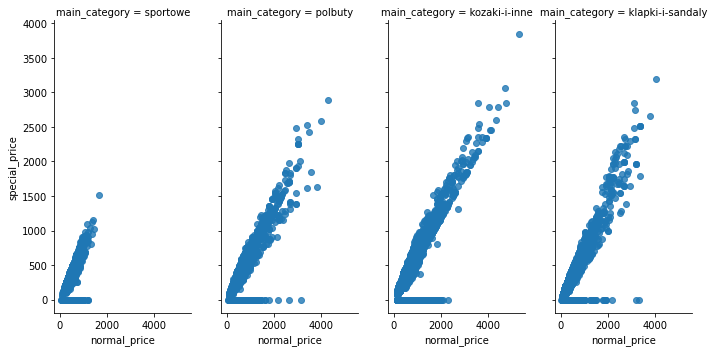

In [ ]:
sns.lmplot(x='normal_price', y='special_price', data=df, fit_reg=False,col='main_category', aspect=0.5)

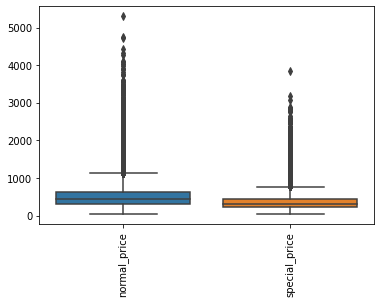

In [ ]:
ax = sns.boxplot(data=df[df['special_price']>0].iloc[:, 4:6])
ax.xaxis.set_tick_params(rotation=90)

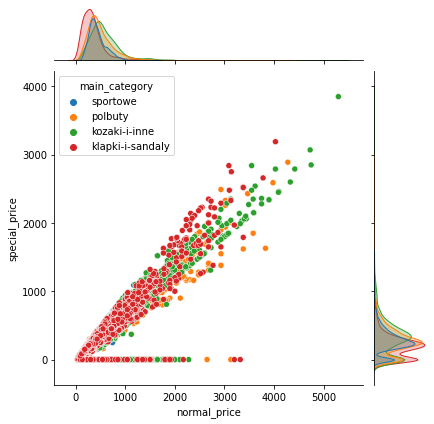

In [ ]:
sns.jointplot(data=df, x='normal_price', y='special_price', hue='main_category')
plt.show()

#REGRESJA LINIOWA - the relationship between normal price and discounted one

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

df_2 = df[df['special_price']>0]
X = df_2[['normal_price']]
y = df_2[['special_price']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

lr = LinearRegression().fit(X_train, y_train)

print(lr.score(X_train, y_train))

0.9387239915870162


In [ ]:
from sklearn.metrics import r2_score

r2_score(y_test, lr.predict(X_test))

0.9389608651538902

In [ ]:
print(f'Regression with coefficients: {round(lr.coef_[0][0],3)} * x + {round(lr.intercept_[0],3)} ')

Regression with coefficients: 0.662 * x + 21.758 


## Log transformation

In [ ]:
X_log = np.log(X)
y_log = np.log(y)
X_train, X_test, y_train, y_test = train_test_split(X_log, y_log, test_size=0.33, random_state=42)

lr = LinearRegression().fit(X_train, y_train)

print(lr.score(X_train, y_train))

0.924678914862784


In [ ]:
from sklearn.metrics import r2_score

r2_score(y_test, lr.predict(X_test))

0.9263889263927366

## Additional variable (main_category)

In [ ]:
category = df.main_category
cat = pd.get_dummies(category)
cat

,klapki-i-sandaly,kozaki-i-inne,polbuty,sportowe
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
28334,1,0,0,0
28335,1,0,0,0
28336,1,0,0,0
28337,1,0,0,0


In [ ]:
cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28339 entries, 0 to 28338
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   klapki-i-sandaly  28339 non-null  uint8
 1   kozaki-i-inne     28339 non-null  uint8
 2   polbuty           28339 non-null  uint8
 3   sportowe          28339 non-null  uint8
dtypes: uint8(4)
memory usage: 110.8 KB


In [ ]:
df = df.join(cat)

In [ ]:
df.sample(5)

,subcategory,shoes_description,image_link,shoes_link,normal_price,special_price,main_category,klapki-i-sandaly,kozaki-i-inne,polbuty,sportowe
12563,Sneakersy Puma,Sneakersy Puma - Karmen Rebelle Mid Exotics 38...,https://img.eobuwie.cloud/eob1_product_300w(7/...,www.eobuwie.com.pl/sneakersy-puma-karmen-rebel...,399.99,289.99,polbuty,0,0,1,0
24015,Klapki GIOSEPPO,Klapki GIOSEPPO - Welda 65923 Black,https://www.eobuwie.com.pl/media/catalog/produ...,www.eobuwie.com.pl/klapki-gioseppo-welda-65923...,219.99,139.99,klapki-i-sandaly,1,0,0,0
9492,Lordsy GINO ROSSI,Lordsy GINO ROSSI - 7309 Blue,https://www.eobuwie.com.pl/media/catalog/produ...,www.eobuwie.com.pl/lordsy-gino-rossi-7309-blue...,329.99,189.99,polbuty,0,0,1,0
25753,Klapki BALDACCINI,Klapki BALDACCINI - 1702000 Fala Srebro,https://www.eobuwie.com.pl/media/catalog/produ...,www.eobuwie.com.pl/klapki-baldaccini-1702000-f...,229.99,179.99,klapki-i-sandaly,1,0,0,0
13566,Trapery TIMBERLAND,Trapery TIMBERLAND - Lucia Way 6in Boot Wp TB0...,https://www.eobuwie.com.pl/media/catalog/produ...,www.eobuwie.com.pl/trapery-timberland-lucia-wa...,899.99,589.99,kozaki-i-inne,0,1,0,0


In [ ]:
df.columns

Index(['subcategory', 'shoes_description', 'image_link', 'shoes_link',
       'normal_price', 'special_price', 'main_category', 'klapki-i-sandaly',
       'kozaki-i-inne', 'polbuty', 'sportowe'],
      dtype='object')

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df_2 = df[df['special_price']>0]
X = df_2[['normal_price','klapki-i-sandaly','kozaki-i-inne','polbuty','sportowe']]
y = df_2[['special_price']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

lr = LinearRegression().fit(X_train_sc, y_train)

print(lr.score(X_train_sc, y_train))

0.9398977961863826


In [ ]:
from sklearn.metrics import r2_score

r2_score(y_test, lr.predict(X_test_sc))

0.9399233751640477

In [ ]:
lr.coef_

array([[ 2.51841406e+02, -2.68608476e+14, -2.74988404e+14,
        -2.78331049e+14, -2.44681401e+14]])

In [ ]:
print(f'Regression with coefficients: ({round(lr.coef_[0][0],3)}) * x1 + ({round(lr.coef_[0][1],3)}) * x2 + ({round(lr.coef_[0][2],3)}) * x3 + ({round(lr.coef_[0][3],3)}) * x4 + ({round(lr.coef_[0][4],3)}) * x5 + ({round(lr.intercept_[0],3)}) ')

Regression with coefficients: (251.841) * x1 + (-268608475865577.2) * x2 + (-274988404015752.34) * x3 + (-278331049042352.06) * x4 + (-244681400623082.94) * x5 + (369.838) 


## Lasso model

In [ ]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=1)

clf.fit(X_train_sc,y_train)
print(clf.score(X_train_sc, y_train))


0.9398449640047949


In [ ]:
from sklearn.metrics import r2_score

r2_score(y_test, clf.predict(X_test_sc))

0.9399076559743367

In [ ]:
clf.coef_

array([250.97021319,  -0.        ,   1.34851789,  -4.76920883,
         4.1479305 ])

In [ ]:
print(f'Regression with coefficients: ({round(clf.coef_[0],3)}) * x1 + ({round(clf.coef_[1],3)}) * x2 + ({round(clf.coef_[2],3)}) * x3 + ({round(clf.coef_[3],3)}) * x4 + ({round(clf.coef_[4],3)}) * x5 + ({round(clf.intercept_[0],3)}) ')

Regression with coefficients: (250.97) * x1 + (-0.0) * x2 + (1.349) * x3 + (-4.769) * x4 + (4.148) * x5 + (369.823) 


#IMAGE CLASSIFICATION - preparation

## Loading images

In [ ]:
columns_name = df.columns[7:]
columns_name

Index(['klapki-i-sandaly', 'kozaki-i-inne', 'polbuty', 'sportowe'], dtype='object')

In [ ]:
#new directories
for col in columns_name:
    directory = col
    parent_dir = "drive/MyDrive/eobuwie/"
    path = os.path.join(parent_dir, directory)
    if not os.path.exists(path):
        os.mkdir(path)

In [ ]:
for col in columns_name:
    parent_dir = "drive/MyDrive/eobuwie/"
    path = os.path.join(parent_dir, col)
    for ind in df.image_link[df[col]==1].index:
        url = df.image_link[ind]
        filename = url.split('/')[-1]
        completeName = os.path.join(path, filename)
        r = requests.get(url, allow_redirects=True)
        open(completeName, 'wb').write(r.content)

'for col in columns_name:\n    parent_dir = "drive/MyDrive/eobuwie/"\n    path = os.path.join(parent_dir, col)\n    for ind in df.image_link[df[col]==1].index:\n        url = df.image_link[ind]\n        filename = url.split(\'/\')[-1]\n        completeName = os.path.join(path, filename)\n        r = requests.get(url, allow_redirects=True)\n        open(completeName, \'wb\').write(r.content)'

## Analyzing images

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import cv2
from glob import glob

In [ ]:
columns_name

Index(['klapki-i-sandaly', 'kozaki-i-inne', 'polbuty', 'sportowe'], dtype='object')

In [ ]:
df_all = pd.DataFrame()
for col in columns_name:
    globals()[f"path_"+col] = glob('/content/drive/MyDrive/eobuwie/{}/*.jpg'.format(col))
    globals()[f"df_"+col] = pd.DataFrame(globals()[f"path_"+col], columns=['filepath'])
    globals()[f"df_"+col]['category'] = col
    df_all = pd.concat((df_all,globals()[f"df_"+col]), axis = 0)

In [ ]:
df_all.category.value_counts()

klapki-i-sandaly    7276
kozaki-i-inne       4325
polbuty             3199
sportowe            3043
Name: category, dtype: int64

In [ ]:
df_all.drop_duplicates(keep='first', inplace=True)

In [ ]:
df_klapki = df_all[df_all['category']=='klapki-i-sandaly'].sample(2500)
df_kozaki = df_all[df_all['category']=='kozaki-i-inne'].sample(2500)
df_polbuty = df_all[df_all['category']=='polbuty'].sample(2500)
df_sportowe = df_all[df_all['category']=='sportowe'].sample(2500)

In [ ]:
df_images = df_klapki.append(df_kozaki.append(df_polbuty.append(df_sportowe)))

In [ ]:
df_images.category.value_counts()

klapki-i-sandaly    2500
kozaki-i-inne       2500
polbuty             2500
sportowe            2500
Name: category, dtype: int64

In [1]:
# return width of image
def get_size(path):
    img = cv2.imread(path)
    return img.shape[0]

df_images['dimension']=df_images['filepath'].apply(get_size)

"def get_size(path):\n    img = cv2.imread(path)\n    return img.shape[0]\n\ndf_images['dimension']=df_images['filepath'].apply(get_size)"

In [ ]:
df_images.dimension.unique()

array([300])

## Resizing images to the same dimensions, gray and flattening, normalization

In [ ]:
#remember that with cv2 we got BGR NOT!!!RGB(this is in matplotlib)
#this funcion flatten the image to one row, make image gray

def transform_image(path):
    try:
        img = cv2.imread(path)
        gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        size = gray_img.shape[0]
        if size >= 200:
            gray_resized = cv2.resize(gray_img,(200,200), cv2.INTER_AREA) #we are shinking the image
        else:
            gray_resized = cv2.resize(gray_img,(200,200), cv2.INTER_CUBIC) #in this case we are enlarging
        flatten_img = gray_resized.flatten() # it will be 200x200 = 40000, (1, 40 000)
        return flatten_img
    except:
        return None

In [ ]:
#transform to the same size

def transform_image_arr(path):
    try:
        img = cv2.imread(path)
        gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        size = gray_img.shape[0]
        if size >= 200:
            gray_resized = cv2.resize(gray_img,(200,200), cv2.INTER_AREA) #we are shinking the image
        else:
            gray_resized = cv2.resize(gray_img,(200,200), cv2.INTER_CUBIC) #in this case we are enlarging

        return gray_resized
    except:
        return None

In [ ]:
#function resizing the image to 100x100, still in color

def transform_image_color(path):
    try:
        img = cv2.imread(path)

        size = img.shape[0]
        if size >= 100:
            img_resized = cv2.resize(img,(100,100), cv2.INTER_AREA) #we are shinking the image
        else:
            img_resized = cv2.resize(img,(100,100), cv2.INTER_CUBIC) #in this case we are enlarging

        return img_resized
    except:
        return None

In [ ]:
def read_image(path):
  img = cv2.imread(path)
  return img

In [ ]:
df_images = df_images.reset_index(drop=True)

In [ ]:
df_images['image_flatten'] = df_images['filepath'].apply(transform_image)

In [ ]:
df_images['arr_gray_resized'] = df_images['filepath'].apply(transform_image_arr)

In [ ]:
df_images['color_img'] = df_images['filepath'].apply(read_image)
df_images['color_img_resized'] = df_images['filepath'].apply(transform_image_color)

In [ ]:
df_images.sample(2)

,filepath,category,image_flatten,arr_gray_resized,color_img,color_img_resized
5249,/content/drive/MyDrive/eobuwie/polbuty/0000300...,polbuty,"[255, 255, 255, 255, 255, 254, 254, 254, 254, ...","[[255, 255, 255, 255, 255, 254, 254, 254, 254,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,..."
2596,/content/drive/MyDrive/eobuwie/kozaki-i-inne/0...,kozaki-i-inne,"[255, 255, 255, 255, 255, 254, 254, 254, 254, ...","[[255, 255, 255, 255, 255, 254, 254, 254, 254,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,..."


In [ ]:
vector_img = df_images['image_flatten'].apply(pd.Series)
vector_img.columns = [f'pixel_{i}' for i in vector_img.columns]
vector_img = vector_img/255. #normalization
vector_img['category'] = df_images['category']
vector_img.sample(5)


,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_39991,pixel_39992,pixel_39993,pixel_39994,pixel_39995,pixel_39996,pixel_39997,pixel_39998,pixel_39999,category
5933,1.0,1.0,1.0,1.0,1.0,0.996078,0.996078,0.996078,0.996078,0.996078,...,0.996078,1.0,0.996078,0.996078,1.0,1.0,1.0,1.0,1.0,polbuty
3944,1.0,1.0,1.0,1.0,1.0,0.996078,0.996078,0.996078,0.996078,0.996078,...,0.996078,1.0,0.996078,0.996078,1.0,1.0,1.0,1.0,1.0,kozaki-i-inne
2872,1.0,1.0,1.0,1.0,1.0,0.996078,0.996078,0.996078,0.996078,0.996078,...,0.996078,1.0,0.996078,0.996078,1.0,1.0,1.0,1.0,1.0,kozaki-i-inne
5136,1.0,1.0,1.0,1.0,1.0,0.996078,0.996078,0.996078,0.996078,0.996078,...,0.996078,1.0,0.996078,0.996078,1.0,1.0,1.0,1.0,1.0,polbuty
7725,1.0,1.0,1.0,1.0,1.0,0.996078,0.996078,0.996078,0.996078,0.996078,...,0.996078,1.0,0.996078,0.996078,1.0,1.0,1.0,1.0,1.0,sportowe


## Eksport data

In [ ]:
# whole data df_
pickle.dump(df_images,open('/content/drive/MyDrive/eobuwie/data_img_df.pickle',mode='wb')) 

In [ ]:
# flatten data with pixels as columns for standard ML models
pickle.dump(vector_img,open('/content/drive/MyDrive/eobuwie/data_img_200_200.pickle',mode='wb')) 